In [76]:
import numpy as np
import pandas as pd

np.random.seed(seed=42)

metasamples = pd.read_excel('../Metadata.xlsx')
metasamples['SAMPLE_ID'] = metasamples['SAMPLE_ID'].astype(str)
metasamples.index = [x.strip() for x in metasamples['SAMPLE_ID'] + '-' + metasamples['PATIENT_ID']]

# Keep only samples that are tumor-normal pair and labeled as included
meta_filtered = metasamples.loc[(metasamples['INCLUDED'] == "Y")
                                & (metasamples['TUMOR_ONLY'] == "No")
                                #& (metasamples['VAR2'].notnull())
                                & (metasamples['baseline_1_more'] == "Y")
                                #& (metasamples['baseline_1'] == "Y")
                                #& (metasamples['MSI_ISH'] == 'MSS')
                                & (metasamples['SAMPLE_TYPE'] != "PDX")
                                & (metasamples['SAMPLE_TYPE'] != "gDNA"), :]
meta_filtered = meta_filtered.drop(labels=['4179_77_cfDNA-VHIO_35'])
#meta_filtered = meta_filtered.drop(labels=['VH_18_B_034996_60_tumor-VHIO_27'])
#meta_filtered = meta_filtered.drop(labels=['M18_2959_80_tumor-VHIO_38'])
meta_filtered = meta_filtered.drop(labels=['JAM_16_19733_A10_MPP216_L18_4331_82_tumor-VHIO_39'])

# Load and filter spectra files
spectra_snp = pd.read_csv('../analysis/merged_maf_spectra_snp_filtered.txt', sep='\t', index_col=0, header=0)
samples_snp = np.intersect1d(meta_filtered.index, spectra_snp.columns)
spectra_snp = spectra_snp.loc[:, samples_snp]
spectra_snp = spectra_snp.dropna()

spectra_indel = pd.read_csv('../analysis/merged_maf_spectra_indel_filtered.txt', sep='\t', index_col=0, header=0)
samples_indel = np.intersect1d(meta_filtered.index, spectra_indel.columns)
spectra_indel = spectra_indel.loc[:, samples_indel]
spectra_indel = spectra_indel.dropna()

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import umap

color_map = ["red", "green", "blue", "orange", "cyan", "yellow", "orchid", 
             "saddlebrown", "darkcyan", "gray", "darkred", "darkgreen", "darkblue", 
             "antiquewhite", "bisque", "black", "slategray", "gold", "floralwhite",
             "aliceblue", "plum", "cadetblue", "coral", "olive", "khaki", "lightsalmon"]

def plot_heatmap(data, meta, title, filename):
    figsize = (16,16)
    cmap = "bwr"
    vmax = None
    vmin = None

    var2 = meta['VAR2'].copy()
    var2.loc[var2 == 'E'] = color_map[1]
    var2.loc[var2 == 'F'] = color_map[2]
    var2.loc[var2.isna()] = color_map[0]
    var2_colors = var2.to_list()
    
    var4 = meta['VAR4'].copy()
    var4.loc[var4 == 'CR'] = color_map[4]
    var4.loc[var4 == 'PD'] = color_map[5]
    var4.loc[var4 == 'PR'] = color_map[6]
    var4.loc[var4 == 'long SD'] = color_map[7]
    var4.loc[var4 == 'short SD'] = color_map[8]
    var4.loc[var4.isna()] = color_map[0]
    var4_colors = var4.to_list()
    
    var5 = meta['MSI_ISH'].copy()
    var5.loc[var5 == 'MSS'] = color_map[9]
    var5.loc[var5 == 'MSI'] = color_map[10]
    var5.loc[var5.isna()] = color_map[0]
    var5_colors = var5.to_list()

    ax = sns.clustermap(data,
                        z_score=None,
                        standard_scale=None,
                        cmap=cmap,
                        rasterized=True,
                        yticklabels=1,
                        metric='euclidean',
                        method='complete',
                        row_colors=[var2_colors, var4_colors, var5_colors],
                        vmax=vmax,
                        vmin=vmin)
    
    handles = [Patch(color=color_map[0], label='Na'),
               Patch(color=color_map[1], label='E'),
               Patch(color=color_map[2], label='F'),
               Patch(color=color_map[4], label='CR'),
               Patch(color=color_map[5], label='PD'),
               Patch(color=color_map[6], label='PR'),
               Patch(color=color_map[7], label='long SD'),
               Patch(color=color_map[8], label='short SD'),
               Patch(color=color_map[9], label='MSS'),
               Patch(color=color_map[10], label='MSI')]
    ax.ax_heatmap.set_title(title, fontsize=18)
    ax.ax_heatmap.set_xlabel("Signatures",fontsize=10)
    ax.ax_heatmap.set_ylabel("Samples", fontsize=10)
    ax.ax_heatmap.tick_params(labelsize=10)
    ax.ax_row_dendrogram.legend(handles=handles, loc="lower left")
    ax.savefig(filename)
    
    
def plot_pca(data, colors, labels, title, filename):

    if data.shape[1] > 2:
        reduced_data = PCA(whiten=False, n_components=2).fit_transform(data)
    else:
        reduced_data = data.to_numpy()
        
    unique_colors = set(colors)
    color_values = [color_map[i] for i in unique_colors]
    colors = [color_map[i] for i in colors]

    fig, ax = plt.subplots(figsize=(12,12))
    sc = ax.scatter(reduced_data[:, 0],
                    reduced_data[:, 1], 
                    c=colors, 
                    edgecolor="none", 
                    cmap=None, 
                    s=40)

    ax.set_xlabel('PCA1', fontsize=16)
    ax.set_ylabel('PCA2', fontsize=16)
    ax.set_title(title, size=18)
    ax.legend([plt.Line2D((0, 1), (0, 0), color=x) for x in color_values],
              labels, loc="upper right", markerscale=1.0,
              ncol=1, scatterpoints=1, fontsize=16)
    fig.savefig(filename)
    
def plot_umap(data, colors, labels, title, filename):
    
    if data.shape[1] > 2:
        reduced_data = umap.UMAP(n_neighbors=5, min_dist=0.01, random_state=42,
                                 n_components=2, metric='euclidean').fit_transform(data)
    else:
        reduced_data = data.to_numpy()
        
    unique_colors = set(colors)
    color_values = [color_map[i] for i in unique_colors]
    colors = [color_map[i] for i in colors]

    fig, ax = plt.subplots(figsize=(12,12))
    sc = ax.scatter(reduced_data[:, 0],
                    reduced_data[:, 1], 
                    c=colors, 
                    edgecolor="none", 
                    cmap=None, 
                    s=40)

    ax.set_xlabel('UMAP1', fontsize=16)
    ax.set_ylabel('UMAP2', fontsize=16)
    ax.set_title(title, size=18)
    ax.legend([plt.Line2D((0, 1), (0, 0), color=x) for x in color_values],
              labels, loc="upper right", markerscale=1.0,
              ncol=1, scatterpoints=1, fontsize=16)
    fig.savefig(filename)

In [50]:
def make_plots(data, meta, name):
    
    plot_heatmap(data, 
                 meta, 
                 'Signatures_{}'.format(name), 
                 'Signatures_{}.pdf'.format(name))
    
    
    meta_slice = meta[meta['VAR2'].notnull()]
    data_slice = data.loc[meta_slice.index.tolist(), :]
    var2_colors = [0 if x == 'E' else 1 for x in meta_slice['VAR2']]
    plot_pca(data_slice, 
             colors=var2_colors,
             labels=['E', 'F'],
             title='Signatures {} (VAR2)'.format(name),
             filename='pca_signature_{}_var2.pdf'.format(name))
    plot_umap(data_slice, 
              colors=var2_colors,
              labels=['E', 'F'],
              title='Signatures {} (VAR2)'.format(name),
              filename='umap_signature_{}_var2.pdf'.format(name))

    meta_slice = meta[meta['VAR4'].notnull()]
    data_slice = data.loc[meta_slice.index.tolist(), :]
    var4 = meta_slice['VAR4'].copy()
    var4.loc[var4 == 'CR'] = 1
    var4.loc[var4 == 'PD'] = 2
    var4.loc[var4 == 'PR'] = 3
    var4.loc[var4 == 'long SD'] = 4
    var4.loc[var4 == 'short SD'] = 5
    var4_colors = var4.to_list()
    labels = ['CR', 'PD', 'PR', 'long SD', 'short SD']
    plot_pca(data_slice, 
             colors=var4_colors,
             labels=labels,
             title='Signatures {} (VAR4)'.format(name),
             filename='pca_signature_{}_var4.pdf'.format(name))
    plot_umap(data_slice, 
              colors=var4_colors,
              labels=labels,
              title='Signatures {} (VAR4)'.format(name),
              filename='umap_signature_{}_var4.pdf'.format(name))

In [75]:
data = spectra_snp.transpose()
data = data.div(data.sum(axis=1), axis=0)
data_norm = np.log1p(data)

for patient, samples in meta_filtered.groupby('PATIENT_ID'):
    print(patient)
    if len(samples) > 1:
        sample1 = samples.index[0]
        sample2 = samples.index[1]
        print('Pearson correlation {} vs {}'.format(sample1, sample2))
        print(pearsonr(data_norm.loc[sample1,:], data_norm.loc[sample2,:]))

VHIO_01
VHIO_13
VHIO_14
Pearson correlation 18_39888_A4__B2010101__43_tumor-VHIO_14 vs 2550_44_cfDNA-VHIO_14
(0.9895195798067499, 8.273044204074291e-81)
VHIO_15
VHIO_16
VHIO_17
VHIO_27
VHIO_28
VHIO_30
Pearson correlation 4113_67_cfDNA-VHIO_30 vs VH___20___B___001520_66_tumor-VHIO_30
(0.8957524150195368, 7.341147295339955e-35)
VHIO_33
Pearson correlation 4150_L-VHIO_33 vs M20-1981-JVC-VHIO_33
(0.9711510982897489, 2.538483711911081e-60)
VHIO_35
VHIO_37
VHIO_38
VHIO_39
VHIO_40
Pearson correlation DAS_16_658947_MPP216_L18_4333_89_tumor-VHIO_40 vs DAS_529_93_cfDNA-VHIO_40
(0.9524561432818692, 2.60418671546042e-50)


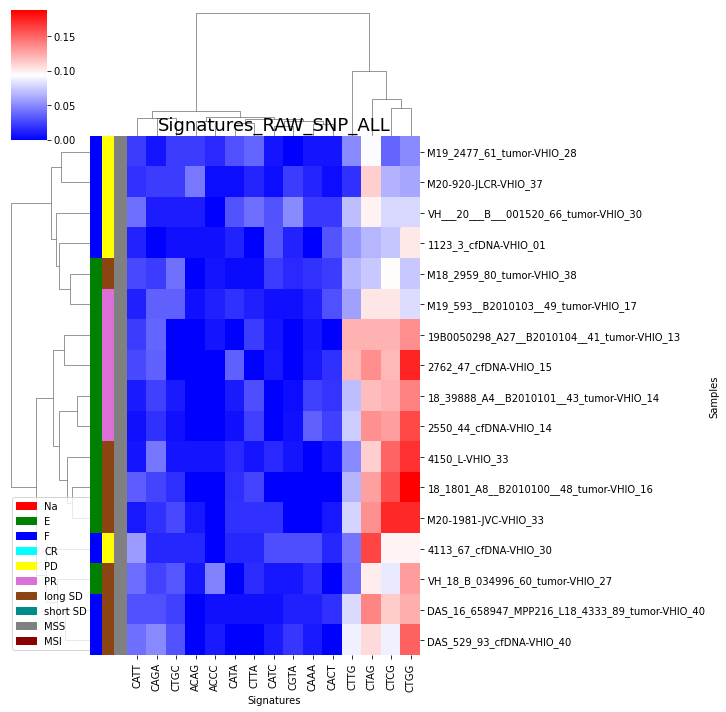

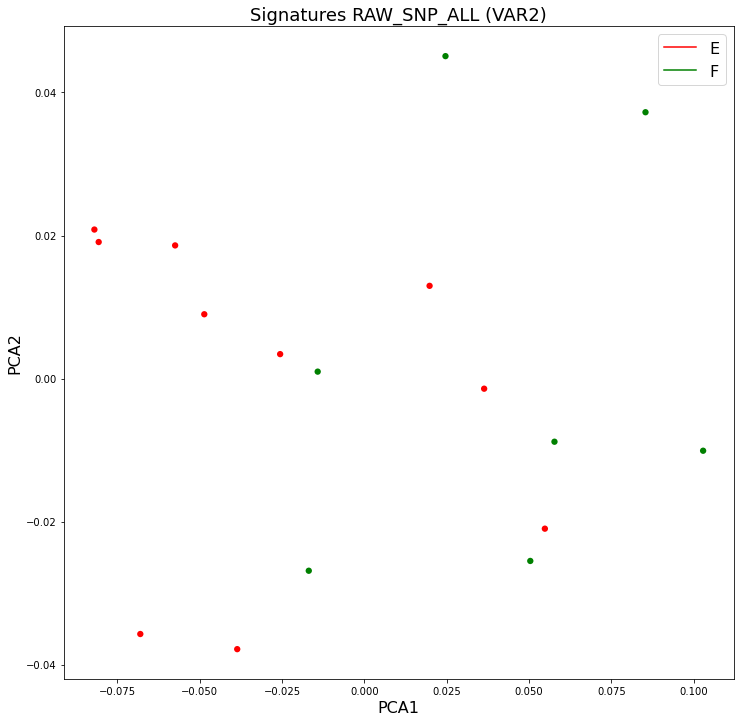

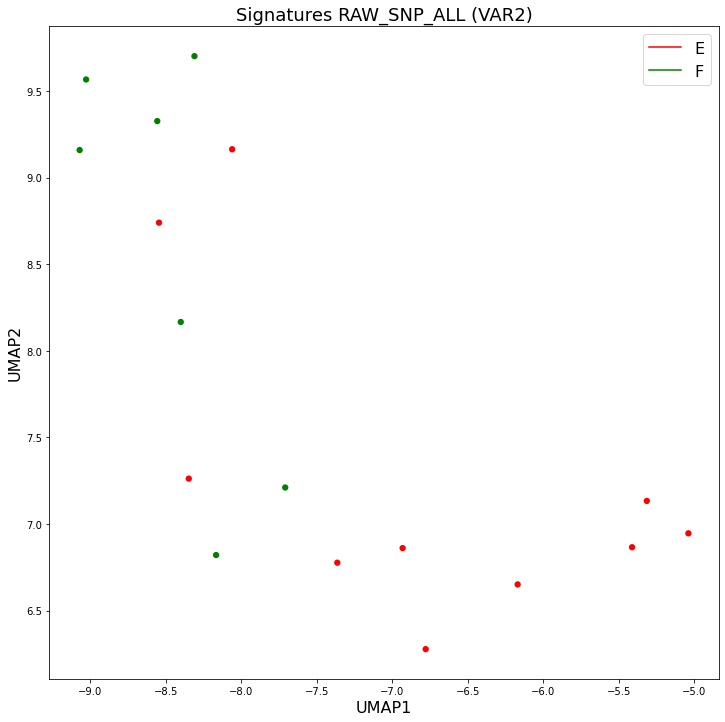

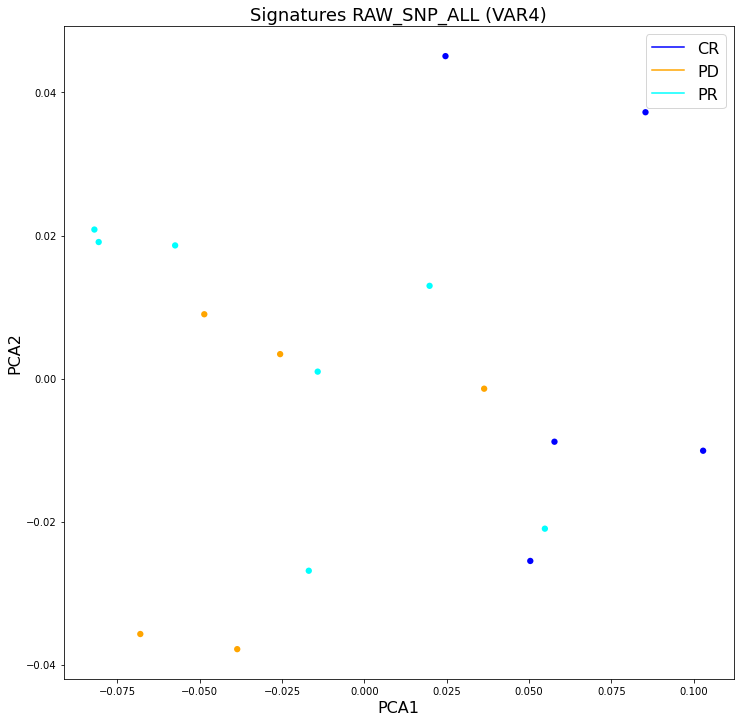

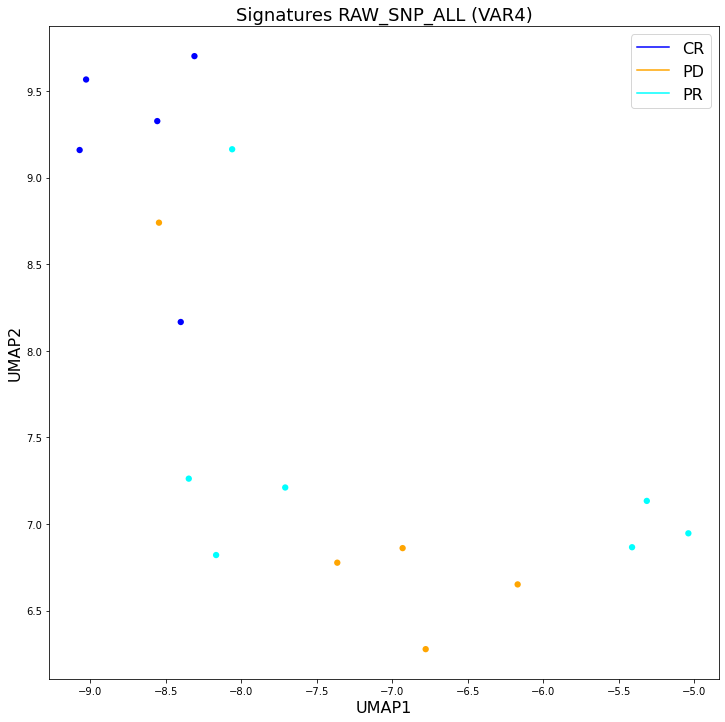

In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

data = spectra_snp.transpose()
data = data.div(data.sum(axis=1), axis=0)
data_norm = np.log1p(data)

sel = VarianceThreshold(threshold=0.0001)
indices = sel.fit(data_norm).get_support()
data_norm = data_norm.loc[:, indices]

make_plots(data_norm, meta_filtered.reindex(data_norm.index), 'RAW_SNP_ALL')